In [ ]:
!pip install -q -U bitsandbytes
!pip install -q -U peft
!pip install -q -U trl
!pip install -q -U accelerate
!pip install transformers
!pip install huggingface_hub --q
!pip install wordcloud
!pip install Levenshtein
!pip install rouge-score
!pip install adapter-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 84.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.0/348.0 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Загрузка моделей

In [ ]:
from huggingface_hub import notebook_login
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, pipeline

In [ ]:
!unzip "/content/all_dialect_model.zip" -d "/content/all_dialect_data"

Archive:  /content/all_dialect_model.zip
replace /content/all_dialect_data/tokenizer.model? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/all_dialect_data/tokenizer.model  
replace /content/all_dialect_data/tokenizer_config.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!unzip "/content/fine_tuned_models.zip"

Archive:  /content/all_dialect_model.zip
  inflating: tokenizer.model         
  inflating: tokenizer_config.json   
  inflating: training_args.bin       
  inflating: README.md               
  inflating: adapter_config.json     
  inflating: adapter_model.safetensors  
  inflating: special_tokens_map.json  
  inflating: tokenizer.json          
Archive:  /content/fine_tuned_models.zip
   creating: my_sql_data/
   creating: pg_data/
   creating: sql_lite_data/
  inflating: my_sql_data/tokenizer.model  
  inflating: my_sql_data/tokenizer_config.json  
  inflating: my_sql_data/training_args.bin  
  inflating: my_sql_data/README.md   
  inflating: my_sql_data/adapter_config.json  
  inflating: my_sql_data/adapter_model.safetensors  
  inflating: my_sql_data/special_tokens_map.json  
  inflating: my_sql_data/tokenizer.json  
  inflating: sql_lite_data/tokenizer.model  
  inflating: sql_lite_data/tokenizer_config.json  
  inflating: sql_lite_data/training_args.bin  
  inflating: sql_lite_d

### Анализ датасета

In [ ]:
from datasets import load_dataset, DatasetDict
from datasets import concatenate_datasets
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import random_split, DataLoader
from tqdm import tqdm
from datasets import Dataset

In [ ]:
file_path = '/content/test_dataset.csv'
dataset = load_dataset('csv', data_files=file_path)
df = pd.read_csv(file_path)
test_dataset = Dataset.from_pandas(df)
dataset

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['natural_languge', 'sql_lite_schema', 'sql_lite_query', 'my_sql_schema', 'my_sql_query', 'pg_schema', 'pg_query', 'ch_schema', 'ch_query'],
        num_rows: 1001
    })
})

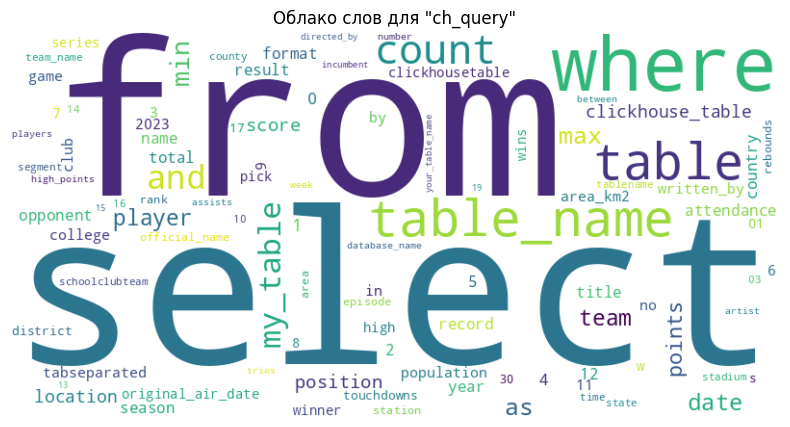

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import re

text_data = dataset['train']['ch_query']
all_text = ' '.join(text_data)
all_text_cleaned = re.sub(r'\W+', ' ', all_text)
word_counts = Counter(all_text_cleaned.lower().split())

wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate_from_frequencies(word_counts)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Облако слов для "ch_query"')
plt.show()

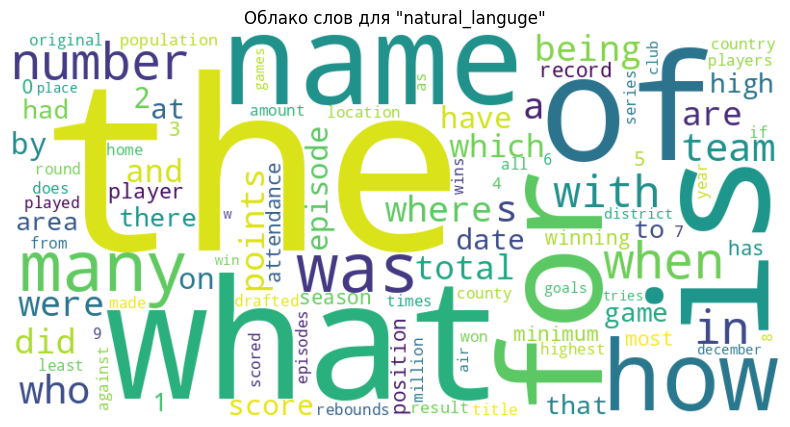

In [ ]:
text_data = dataset['train']['natural_languge']
all_text = ' '.join(text_data)
all_text_cleaned = re.sub(r'\W+', ' ', all_text)
word_counts = Counter(all_text_cleaned.lower().split())

wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate_from_frequencies(word_counts)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Облако слов для "natural_languge"')
plt.show()

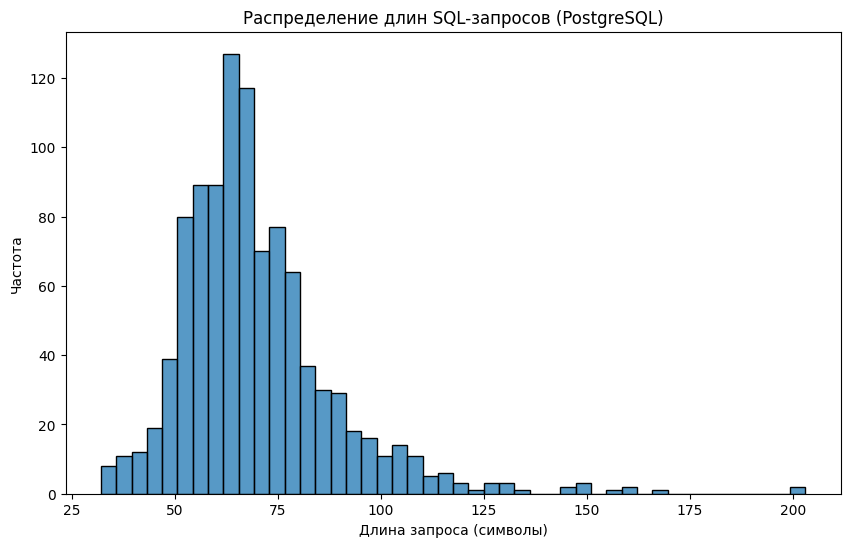

In [ ]:
df = dataset['train'].to_pandas()

df['pg_query_length'] = df['pg_query'].str.len()
plt.figure(figsize=(10, 6))
sns.histplot(df['pg_query_length'])
plt.title('Распределение длин SQL-запросов (PostgreSQL)')
plt.xlabel('Длина запроса (символы)')
plt.ylabel('Частота')
plt.show()

### Подготовка датасета

In [ ]:
import random

prompt_template = """<start_of_turn>user
You are an intelligent AI specialized in generating SQL queries.
Your task is to translate {db_name} into Clickhouse.
Please provide the SQL query corresponding to the given prompt and context:
Prompt:
translate {db_name} into Clickhouse
Context:
Natural language: {natural_language}
{ch_schema_part}
{query_part}
<end_of_turn>
<start_of_turn>model
"""


def tokenize_function(examples, db_name, dialect_column):
    inputs = []
    for natural_language, schema, query in zip(
        examples['natural_languge'],
        examples['ch_schema'],
        examples[dialect_column]
    ):
        ch_schema_part = f"ClickHouse schema: {schema}" if schema else ""
        query_part = f"{db_name} query: {query}" if query else ""
        filled_prompt = prompt_template.format(
            db_name=db_name,
            natural_language=natural_language,
            ch_schema_part=ch_schema_part,
            query_part=query_part,
        )
        inputs.append(filled_prompt)

    model_inputs = {}
    model_inputs["prompt"] = inputs
    return model_inputs


In [ ]:
from functools import partial

my_sql_tokenize = partial(tokenize_function, db_name='MY SQL', dialect_column='my_sql_query')
sql_lite_tokenize = partial(tokenize_function, db_name='SQL LITE', dialect_column='sql_lite_query')
pg_tokenize = partial(tokenize_function, db_name='Postgree', dialect_column='pg_query')

my_sql_tokenized_test = test_dataset.map(my_sql_tokenize, batched=True)
sql_lite_tokenized_test = test_dataset.map(sql_lite_tokenize, batched=True)
pg_tokenized_test = test_dataset.map(pg_tokenize, batched=True)

Map:   0%|          | 0/1001 [00:00<?, ? examples/s]

Map:   0%|          | 0/1001 [00:00<?, ? examples/s]

Map:   0%|          | 0/1001 [00:00<?, ? examples/s]

In [ ]:
combined_dataset_test = concatenate_datasets([
    sql_lite_tokenized_test.select(range(200)),
    my_sql_tokenized_test.select(range(200)),
    pg_tokenized_test.select(range(200))
])

In [ ]:
my_sql_tokenized_test
my_sql_tokenized_test[0]

{'natural_languge': "What was the location and attendance when the team's record was 16-44?",
 'sql_lite_schema': 'CREATE TABLE IF NOT EXISTS table_name ( Location TEXT, Attendance INTEGER, Record TEXT );',
 'sql_lite_query': "SELECT Location, Attendance FROM table_name WHERE Record = '16-44'",
 'my_sql_schema': 'CREATE TABLE my_table ( Location VARCHAR(255), Attendance INT, Record VARCHAR(255) );',
 'my_sql_query': "SELECT Location, Attendance FROM my_table WHERE Record = '16-44';",
 'pg_schema': 'CREATE TABLE IF NOT EXISTS attendance ( id SERIAL PRIMARY KEY, location VARCHAR(255), attendance INT, record VARCHAR(255) );',
 'pg_query': "SELECT location, attendance FROM attendance WHERE record = '16-44';",
 'ch_schema': 'CREATE TABLE IF NOT EXISTS my_table ( Location String, Attendance UInt32 ) ENGINE = MergeTree() ORDER BY Location;',
 'ch_query': "SELECT Location, Attendance FROM my_table WHERE Record = '16-44'",
 'prompt': "<start_of_turn>user\nYou are an intelligent AI specialized i

### Проверка предобученной модели

In [ ]:
import Levenshtein
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)


def calculate_metrics(sql_converter, dataset, device, max_new_tokens=100, temperature=1.0, tolerance=0.1):
    rouge1_scores = []
    rougeL_scores = []
    correct_predictions = 0
    total_samples = len(dataset)

    with torch.no_grad():
        for data_point in tqdm(dataset, desc="Evaluating"):
            prompt = data_point['prompt']
            natural_languge = data_point['natural_languge']
            ground_truth_query = data_point['ch_query'].strip()

            result = sql_converter(
              data_point['prompt'],
              eos_token_id=1,
              pad_token_id=1,
              do_sample=False
            )[0]["generated_text"]
            generated_query = result.split('<start_of_turn>model')[1]

            model_answer = generated_query.strip()
            if ';' in model_answer:
                model_answer = model_answer.split(';')[0] + ';'
            distance = Levenshtein.distance(model_answer, ground_truth_query)
            max_distance = len(ground_truth_query) * tolerance
            if distance <= max_distance:
                correct_predictions += 1

            # rouge
            scores = scorer.score(data_point['ch_query'].strip(), model_answer)
            rouge1_scores.append(scores["rouge1"].fmeasure)
            rougeL_scores.append(scores["rougeL"].fmeasure)

    accuracy = correct_predictions / total_samples
    print(f"Distance accuracy: {accuracy}")

    avg_rouge1 = sum(rouge1_scores) / len(rouge1_scores)
    avg_rougeL = sum(rougeL_scores) / len(rougeL_scores)
    print(f"Average ROUGE-1: {avg_rouge1}")
    print(f"Average ROUGE-L: {avg_rougeL}")

    return accuracy, avg_rouge1, avg_rougeL


In [ ]:
sql_lite_directory = '/content/sql_lite_data'
my_sql_directory = '/content/my_sql_data'
pg_directory = '/content/pg_data'
all_dialect_directory = '/content/all_dialect_data'

In [ ]:
torch.set_grad_enabled(False)

In [ ]:
from transformers import pipeline

sql_lite_trained_tokenizer = AutoTokenizer.from_pretrained(sql_lite_directory)
sql_lite_trained_model = AutoModelForCausalLM.from_pretrained(sql_lite_directory)
sql_lite_trained_model.eval()


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

GemmaForCausalLM(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear(in_features=16384, out_features=2048, bias=False)
          (act_fn): GELUActivation()
        )
        (input_layernorm): GemmaRMSNorm((2048,), eps=1e-06)
        (post_attention_layernorm): GemmaRMSNorm((2048,), eps=1e-06)
      )
    )
    (norm): GemmaRMSNorm((2048,), 

In [ ]:
sql_lite_converter = pipeline(
    "text-generation",
    model=sql_lite_trained_model,
    tokenizer=sql_lite_trained_tokenizer,
    device="cuda"
)

Device set to use cuda


In [ ]:
calculate_metrics(sql_lite_converter, sql_lite_tokenized_test.select(range(250)), "cuda")

Evaluating: 100%|██████████| 250/250 [02:04<00:00,  2.01it/s]

Distance accuracy: 0.28
Average ROUGE-1: 0.8315882560061999
Average ROUGE-L: 0.8217018791082441


(0.28, 0.8315882560061999, 0.8217018791082441)

In [ ]:
my_sql_trained_tokenizer = AutoTokenizer.from_pretrained(my_sql_directory)
my_sql_trained_model = AutoModelForCausalLM.from_pretrained(my_sql_directory)
my_sql_trained_model.eval()

my_sql_converter = pipeline(
    "text-generation",
    model=my_sql_trained_model,
    tokenizer=my_sql_trained_tokenizer,
    device="cuda"
)

calculate_metrics(my_sql_converter, my_sql_tokenized_test.select(range(250)), "cuda")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda
Evaluating: 100%|██████████| 250/250 [02:03<00:00,  2.02it/s]

Distance accuracy: 0.3
Average ROUGE-1: 0.8449288345378209
Average ROUGE-L: 0.8383387911428887


(0.3, 0.8449288345378209, 0.8383387911428887)

In [ ]:
pg_trained_tokenizer = AutoTokenizer.from_pretrained(pg_directory)
pg_trained_model = AutoModelForCausalLM.from_pretrained(pg_directory)
pg_trained_model.eval()

pg_converter = pipeline(
    "text-generation",
    model=pg_trained_model,
    tokenizer=pg_trained_tokenizer,
    device="cuda"
)

calculate_metrics(pg_converter, pg_tokenized_test.select(range(250)), "cuda")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda
Evaluating: 100%|██████████| 250/250 [02:03<00:00,  2.02it/s]

Distance accuracy: 0.232
Average ROUGE-1: 0.8267066155473781
Average ROUGE-L: 0.8181995546688002


(0.232, 0.8267066155473781, 0.8181995546688002)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
all_dialect_trained_tokenizer = AutoTokenizer.from_pretrained(all_dialect_directory)
all_dialect_trained_model = AutoModelForCausalLM.from_pretrained(all_dialect_directory)
all_dialect_trained_model.eval()
all_dialects_converter = pipeline(
    "text-generation",
    model=all_dialect_trained_model,
    tokenizer=all_dialect_trained_tokenizer,
    device="cuda"
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda


In [ ]:
calculate_metrics(all_dialects_converter, combined_dataset_test.select(range(250)), "cuda")

Evaluating: 100%|██████████| 250/250 [02:28<00:00,  1.68it/s]

Distance accuracy: 0.064
Average ROUGE-1: 0.48866253860436987
Average ROUGE-L: 0.46967555430505425


(0.064, 0.48866253860436987, 0.46967555430505425)

In [ ]:
calculate_metrics(all_dialects_converter, pg_tokenized_test.select(range(250)), "cuda")

Evaluating: 100%|██████████| 250/250 [02:28<00:00,  1.68it/s]

Distance accuracy: 0.096
Average ROUGE-1: 0.4553813106505821
Average ROUGE-L: 0.43234531200939863


(0.096, 0.4553813106505821, 0.43234531200939863)

In [ ]:
calculate_metrics(all_dialects_converter, my_sql_tokenized_test.select(range(250)), "cuda")

Evaluating: 100%|██████████| 250/250 [02:28<00:00,  1.68it/s]

Distance accuracy: 0.08
Average ROUGE-1: 0.4124871887708995
Average ROUGE-L: 0.395734294621268


(0.08, 0.4124871887708995, 0.395734294621268)

In [ ]:
calculate_metrics(all_dialects_converter, sql_lite_tokenized_test.select(range(250)), "cuda")

Evaluating: 100%|██████████| 250/250 [02:28<00:00,  1.68it/s]

Distance accuracy: 0.108
Average ROUGE-1: 0.5497635536833765
Average ROUGE-L: 0.5314941539437507


(0.108, 0.5497635536833765, 0.5314941539437507)

📊 Результы:

| СУБД                 |    BLEU / ROUGE-1 / ROUGE-L      |
|----------------------|----------------------------------|
| Postgres → CH        | 0.232 / 0.8267 / 0.8181          |
| MySQL → CH           | 0.3 / 0.8449 / 0.838             |
| SQLite   → CH        | 0.28 / 0.832 / 0.8217            |
| Все диалекты → CH    | 0.064 / 0.4887 / 0.4697          |
| Базовая модель → CH  | 0.1213 / 0.1157 / 0.1157         |

 ## Измерение метрик при разных значениях температуры

In [ ]:
def plot_accuracy_vs_temperature(model, tokenizer, dataset, device, temperatures, max_new_tokens=100, do_sample=False):
    """
    Calculates and plots the accuracy (represented by Rouge-1 and Rouge-L) of the model at different temperatures.

    Args:
        model: The language model.
        tokenizer: The tokenizer.
        dataset: The dataset.
        device: The device.
        temperatures: A list of temperature values to test.
        max_new_tokens: The maximum number of tokens to generate.  Set to 1000 to match model.generate function
    """

    avg_rouge1_list = []
    avg_rougeL_list = []

    for temperature in temperatures:
        avg_rouge1, avg_rougeL = calculate_sql_rouge(model, tokenizer, dataset, device, max_new_tokens=1000, temperature=temperature, do_sample=do_sample)  # match model.generate function for max_new_tokens
        avg_rouge1_list.append(avg_rouge1)
        avg_rougeL_list.append(avg_rougeL)
        print(f"Temperature: {temperature}, avg_rouge1: {avg_rouge1}, avg_rougeL: {avg_rougeL}")

    plt.figure(figsize=(12, 6))

    # Plot ROUGE-1
    plt.subplot(1, 2, 1)
    plt.plot(temperatures, avg_rouge1_list, marker='o', linestyle='-', color='blue')
    plt.xlabel("Temperature")
    plt.ylabel("Average ROUGE-1")
    plt.title("ROUGE-1 vs. Temperature")
    plt.grid(True)

    # Plot ROUGE-L
    plt.subplot(1, 2, 2)
    plt.plot(temperatures, avg_rougeL_list, marker='o', linestyle='-', color='green')
    plt.xlabel("Temperature")
    plt.ylabel("Average ROUGE-L")
    plt.title("ROUGE-L vs. Temperature")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

Evaluating: 100%|██████████| 10/10 [23:07<00:00, 138.74s/it]


Average ROUGE-1: 0.7573021114774271
Average ROUGE-L: 0.7265661807414965
Temperature: 0.5, avg_rouge1: 0.7573021114774271, avg_rougeL: 0.7265661807414965


Evaluating: 100%|██████████| 10/10 [20:09<00:00, 120.96s/it]


Average ROUGE-1: 0.5969145992450872
Average ROUGE-L: 0.5665574563879444
Temperature: 1.0, avg_rouge1: 0.5969145992450872, avg_rougeL: 0.5665574563879444


Evaluating: 100%|██████████| 10/10 [11:39<00:00, 69.92s/it] 


Average ROUGE-1: 0.48866425878007264
Average ROUGE-L: 0.47858022516662724
Temperature: 1.25, avg_rouge1: 0.48866425878007264, avg_rougeL: 0.47858022516662724


Evaluating: 100%|██████████| 10/10 [07:01<00:00, 42.11s/it]


Average ROUGE-1: 0.32749771833759106
Average ROUGE-L: 0.3045163518779637
Temperature: 1.5, avg_rouge1: 0.32749771833759106, avg_rougeL: 0.3045163518779637


Evaluating: 100%|██████████| 10/10 [12:19<00:00, 73.91s/it]


Average ROUGE-1: 0.23364729561620418
Average ROUGE-L: 0.21999459243482783
Temperature: 1.75, avg_rouge1: 0.23364729561620418, avg_rougeL: 0.21999459243482783


Evaluating: 100%|██████████| 10/10 [09:20<00:00, 56.07s/it]


Average ROUGE-1: 0.23305682313222115
Average ROUGE-L: 0.20802623610489598
Temperature: 2.0, avg_rouge1: 0.23305682313222115, avg_rougeL: 0.20802623610489598


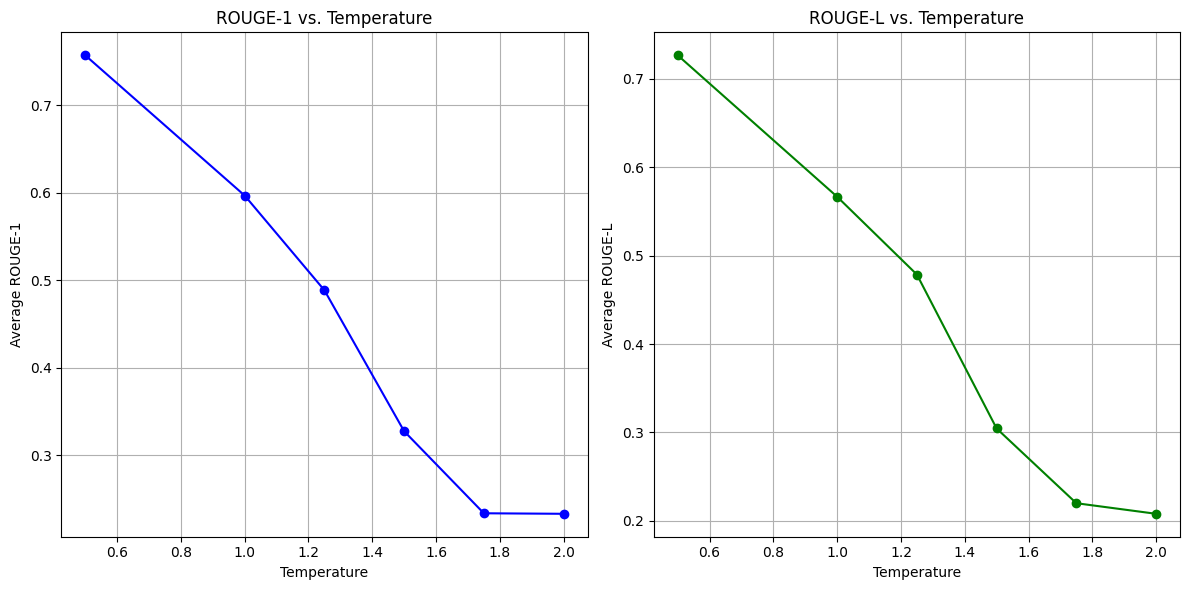

In [ ]:
temperatures = [0.5, 1.0, 1.25, 1.5, 1.75, 2.0]
plot_accuracy_vs_temperature(model, tokenizer, test_dataset.select(range(10)), device, temperatures, do_sample=True)

# Генерация ответов моделей, сравнение с эталонными

In [ ]:
def print_model_vs_correct_answer(sql_converter, dataset):
    with torch.no_grad():
        for data_point in dataset:
            natural_languge = data_point['natural_languge']
            ground_truth_query = data_point['ch_query'].strip()
            result = sql_converter(
              data_point['prompt'],
              eos_token_id=1,
              pad_token_id=1,
              do_sample=False
            )[0]["generated_text"]
            generated_query = result.split('<start_of_turn>model')[1]
            model_answer = generated_query.strip()
            if '<' in model_answer:
                model_answer = model_answer.split('<')[0]
            print(f"natural_languge: {natural_languge}")
            print(f"ground_truth_query: {ground_truth_query}")
            print(f"model_answer: {model_answer}")
            print(f"-" * 40)

## Генерация sql_lite ответов

In [ ]:
print_model_vs_correct_answer(sql_lite_converter, sql_lite_tokenized_test.select(range(50)))

natural_languge: What was the location and attendance when the team's record was 16-44?
ground_truth_query: SELECT Location, Attendance FROM my_table WHERE Record = '16-44'
model_answer: SELECT Location, Attendance FROM table_name WHERE Record = '16-44';

----------------------------------------
natural_languge: What day was the game at chicago?
ground_truth_query: SELECT Date FROM table WHERE Team = 'Chicago';
model_answer: SELECT Date FROM table_name WHERE Team = 'Chicago';

----------------------------------------
natural_languge: Who were the high point scorers in game 7?
ground_truth_query: SELECT High_points FROM table_name WHERE Game = 7;
model_answer: SELECT High_points FROM table WHERE Game = 7;

----------------------------------------
natural_languge: Who had the high rebound total against golden state?
ground_truth_query: SELECT Rebounds FROM nba_stats WHERE Team = 'Golden State';
model_answer: SELECT High, rebounds FROM table_name WHERE Team = 'Golden State';

------------

## Генерация my_sql ответов

In [ ]:
print_model_vs_correct_answer(my_sql_converter, my_sql_tokenized_test.select(range(50)))

natural_languge: What was the location and attendance when the team's record was 16-44?
ground_truth_query: SELECT Location, Attendance FROM my_table WHERE Record = '16-44'
model_answer: SELECT Location, Attendance FROM my_table WHERE Record = '16-44';

----------------------------------------
natural_languge: What day was the game at chicago?
ground_truth_query: SELECT Date FROM table WHERE Team = 'Chicago';
model_answer: SELECT Date FROM table_name WHERE Team = 'Chicago';

----------------------------------------
natural_languge: Who were the high point scorers in game 7?
ground_truth_query: SELECT High_points FROM table_name WHERE Game = 7;
model_answer: SELECT High_points FROM points_table WHERE Game = 7;

----------------------------------------
natural_languge: Who had the high rebound total against golden state?
ground_truth_query: SELECT Rebounds FROM nba_stats WHERE Team = 'Golden State';
model_answer: SELECT rebounds AS High_rebounds FROM players WHERE team = 'Golden State';


## Генерация postgree

In [ ]:
print_model_vs_correct_answer(pg_converter, pg_tokenized_test.select(range(50)))

natural_languge: What was the location and attendance when the team's record was 16-44?
ground_truth_query: SELECT Location, Attendance FROM my_table WHERE Record = '16-44'
model_answer: SELECT location, attendance FROM attendance WHERE record = '16-44';

----------------------------------------
natural_languge: What day was the game at chicago?
ground_truth_query: SELECT Date FROM table WHERE Team = 'Chicago';
model_answer: SELECT date FROM team_stats WHERE team = 'Chicago';

----------------------------------------
natural_languge: Who were the high point scorers in game 7?
ground_truth_query: SELECT High_points FROM table_name WHERE Game = 7;
model_answer: SELECT High_points FROM table_name WHERE Game = 7;

----------------------------------------
natural_languge: Who had the high rebound total against golden state?
ground_truth_query: SELECT Rebounds FROM nba_stats WHERE Team = 'Golden State';
model_answer: SELECT Rebounds AS "High rebounds" FROM basketball_stats WHERE Team = 'Gold

## Генерация all_dialects

In [ ]:
print_model_vs_correct_answer(all_dialects_converter, combined_dataset_test.select(range(50)))

natural_languge: What was the location and attendance when the team's record was 16-44?
ground_truth_query: SELECT Location, Attendance FROM my_table WHERE Record = '16-44'
model_answer: 16-44 SELECT Location, Attendance FROM table_name WHERE Record = '16-
----------------------------------------
natural_languge: What day was the game at chicago?
ground_truth_query: SELECT Date FROM table WHERE Team = 'Chicago';
model_answer: 10000000000000000000
----------------------------------------
natural_languge: Who were the high point scorers in game 7?
ground_truth_query: SELECT High_points FROM table_name WHERE Game = 7;
model_answer: SELECT High_points FROM table WHERE Game = 7;

----------------------------------------
natural_languge: Who had the high rebound total against golden state?
ground_truth_query: SELECT Rebounds FROM nba_stats WHERE Team = 'Golden State';
model_answer: 1 SELECT High, rebounds FROM table_name WHERE Team = 'Golden State';

----------------------------------------


Вывод: модель обученная на корпусе со всеми диалектами за такое же количество ресурсов и время, работает намного хуже, чем модели, которые обучались на решение конретных задаче. В дипломной работе рассмотреныпримеры